In [13]:
import pandas as pd
import numpy as np

solar_pred = pd.read_csv(r"C:\Users\tomas\IE_Datathon\Solar_Prediction.csv", parse_dates=['Datetime'])
actual_used = pd.read_csv(r"C:\Users\tomas\Downloads\repsol_dataset\Consumo_fotovoltaica.csv", parse_dates=['FECHA'])
actual_used.rename(columns={'FECHA': 'Datetime', 'TOTAL_KWH_ENERGIA': 'ACTUAL_USED'}, inplace=True)

In [14]:
grid_demand = pd.read_csv(r"C:\Users\tomas\IE_Datathon\Consumo_sept.csv", parse_dates=['FECHA'])
grid_demand.rename(columns={'FECHA': 'Datetime', 'TOTAL_KWH_ENERGIA': 'GRID_CONSUMED'}, inplace=True)

In [15]:
grid_demand

,Datetime,GRID_CONSUMED
0,2024-09-01 00:00:00,110.855888
1,2024-09-01 01:00:00,107.341202
2,2024-09-01 02:00:00,105.550308
3,2024-09-01 03:00:00,106.840103
4,2024-09-01 04:00:00,105.879791
...,...,...
715,2024-09-30 19:00:00,532.989990
716,2024-09-30 20:00:00,484.213684
717,2024-09-30 21:00:00,243.039886
718,2024-09-30 22:00:00,111.581192


In [16]:
carbon = pd.read_csv(r"C:\Users\tomas\Downloads\repsol_dataset\ES_2024_hourly.csv", parse_dates=['Datetime (UTC)'])
carbon = carbon[carbon['Country'] == 'Spain']
carbon = carbon[['Datetime (UTC)', 'Carbon Intensity gCO₂eq/kWh (direct)']]
carbon.rename(columns={'Carbon Intensity gCO₂eq/kWh (direct)': 'CARBON_INTENSITY'}, inplace=True)
carbon = carbon[(carbon['Datetime (UTC)'] >= '2024-09-01') & (carbon['Datetime (UTC)'] < '2024-10-01')]

In [17]:
solar_pred['Datetime'] = solar_pred['Datetime'].dt.tz_localize(None)
actual_used['Datetime'] = actual_used['Datetime'].dt.tz_localize(None)
grid_demand['Datetime'] = grid_demand['Datetime'].dt.tz_localize(None)
carbon['Datetime'] = carbon['Datetime (UTC)'].dt.tz_localize(None)

df = solar_pred.merge(actual_used, on='Datetime', how='left')
df = df.merge(grid_demand, on='Datetime', how='left')
df = df.merge(carbon, on='Datetime', how='left')

In [18]:
df

,Datetime,KWH_ENERGIA,ACTUAL_USED,GRID_CONSUMED,Datetime (UTC),CARBON_INTENSITY
0,2024-09-01 00:00:00,0.018634,0.00,110.855888,2024-09-01 00:00:00,170.04
1,2024-09-01 01:00:00,0.018634,0.00,107.341202,2024-09-01 01:00:00,175.13
2,2024-09-01 02:00:00,0.017737,0.00,105.550308,2024-09-01 02:00:00,175.53
3,2024-09-01 03:00:00,-0.041720,0.00,106.840103,2024-09-01 03:00:00,174.22
4,2024-09-01 04:00:00,-0.041720,0.00,105.879791,2024-09-01 04:00:00,175.05
...,...,...,...,...,...,...
715,2024-09-30 19:00:00,37.832109,36.74,532.989990,2024-09-30 19:00:00,164.57
716,2024-09-30 20:00:00,11.605677,4.98,484.213684,2024-09-30 20:00:00,156.86
717,2024-09-30 21:00:00,0.310481,-0.04,243.039886,2024-09-30 21:00:00,144.21
718,2024-09-30 22:00:00,0.057147,0.00,111.581192,2024-09-30 22:00:00,121.51


In [19]:
# Calculate EXCESS solar
df['EXCESS_SOLAR'] = df['KWH_ENERGIA'] - df['ACTUAL_USED']
df['EXCESS_SOLAR'] = df['EXCESS_SOLAR'].clip(lower=0)

In [20]:
# Prepare tracking columns
df['ENERGY_CHARGED'] = 0.0
df['ENERGY_DISCHARGED'] = 0.0
df['CO2_AVOIDED'] = 0.0

In [21]:
df = df.fillna(0)

In [22]:
# Simulate day-by-day energy charging and discharging
for day, day_df in df.groupby(df['Datetime'].dt.date):  # Loop through each unique date
    # Sort the day’s data chronologically
    day_df = day_df.sort_values('Datetime')
    
    # Copy available excess solar energy for this day
    charge_available = day_df['EXCESS_SOLAR'].copy()
    
    charged = 0  # Track total energy charged for the day

    # Loop over each hour to simulate charging
    for i in range(len(day_df)):
        if charged >= 100:  # Maximum daily battery capacity is 100 units
            break
        # Determine how much can be charged in this hour
        charge_possible = min(100 - charged, 100, charge_available.iloc[i])
        
        # Store the charged energy in the main DataFrame
        df.loc[day_df.index[i], 'ENERGY_CHARGED'] = charge_possible
        
        # Accumulate the total charged energy
        charged += charge_possible

    # Identify hours with the highest carbon intensity first for discharging
    discharge_hours = day_df.sort_values('CARBON_INTENSITY', ascending=False)
    
    discharged = 0  # Track total energy discharged for the day

    # Loop through hours in descending carbon intensity to maximize CO2 avoided
    for i in discharge_hours.index:
        if discharged >= 100:  # Maximum daily discharging limit is 100 units
            break
        # Determine how much of the grid consumption can be replaced (discharged)
        grid_need = df.loc[i, 'GRID_CONSUMED']
        
        # Discharge either what's needed or what's remaining in capacity
        discharge = min(100 - discharged, grid_need)
        
        # Store discharged energy and corresponding CO2 avoided
        df.loc[i, 'ENERGY_DISCHARGED'] = discharge
        df.loc[i, 'CO2_AVOIDED'] = discharge * df.loc[i, 'CARBON_INTENSITY']
        
        # Accumulate total discharged energy
        discharged += discharge


In [35]:
# Prevent factory from using more solar than it could have generated at any given hour
df['PV_USED_CAPPED'] = df[['KWH_ENERGIA', 'ACTUAL_USED']].min(axis=1)
total_generated = df['KWH_ENERGIA'].sum()
total_direct_used = df['PV_USED_CAPPED'].sum()
total_battery_used = df['ENERGY_DISCHARGED'].sum()

numerator = total_direct_used + total_battery_used
Ra = round(min(numerator, total_generated) / total_generated * 100, 4)

print(" Ra (Self-Consumption Ratio %):", Ra)

# Save CO2_Avoided output file (for Objective 3 too)
df_out = df[['Datetime', 'CO2_AVOIDED']]
df_out

 Ra (Self-Consumption Ratio %): 100.0


,Datetime,CO2_AVOIDED
0,2024-09-01 00:00:00,0.000000
1,2024-09-01 01:00:00,0.000000
2,2024-09-01 02:00:00,8140.901467
3,2024-09-01 03:00:00,0.000000
4,2024-09-01 04:00:00,0.000000
...,...,...
715,2024-09-30 19:00:00,0.000000
716,2024-09-30 20:00:00,0.000000
717,2024-09-30 21:00:00,0.000000
718,2024-09-30 22:00:00,0.000000


In [32]:
print("Total PV Generated:", total_generated)
print("PV Used Directly:", total_direct_used)
print("Battery Energy Used:", total_battery_used)
print("Total PV Used (Direct + Battery):", total_direct_used + total_battery_used)

Total PV Generated: 19277.693297181122
PV Used Directly: 21223.47
Battery Energy Used: 3000.0
Total PV Used (Direct + Battery): 24223.47


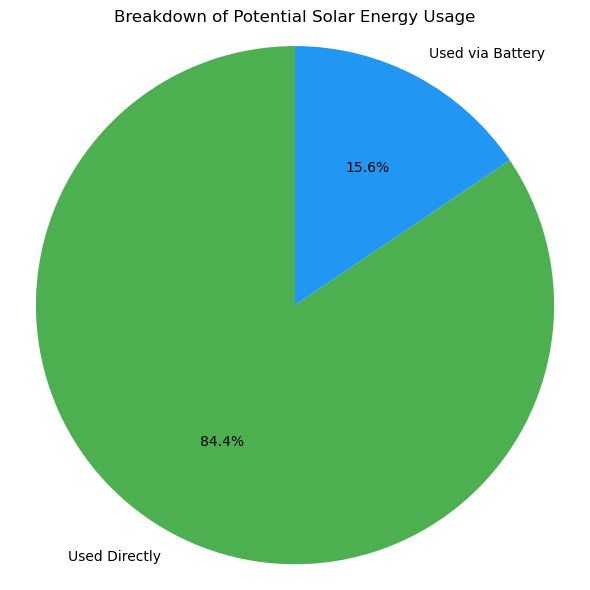

In [38]:
import matplotlib.pyplot as plt

# Use your actual values
direct_used = total_direct_used
battery_used = total_battery_used
unused = max(total_generated - (direct_used + battery_used), 0)

labels = ['Used Directly', 'Used via Battery']
sizes = [direct_used, battery_used]
colors = ['#4CAF50', '#2196F3']

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Breakdown of Potential Solar Energy Usage')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [39]:
df_out[df_out['CO2_AVOIDED']!=0]

,Datetime,CO2_AVOIDED
2,2024-09-01 02:00:00,8140.901467
20,2024-09-01 20:00:00,9424.431369
30,2024-09-02 06:00:00,18341.000000
54,2024-09-03 06:00:00,16101.000000
91,2024-09-04 19:00:00,15891.000000
114,2024-09-05 18:00:00,15877.000000
140,2024-09-06 20:00:00,15512.000000
163,2024-09-07 19:00:00,6657.007170
164,2024-09-07 20:00:00,9135.293463
171,2024-09-08 03:00:00,14506.000000


In [40]:
# Optional: Recalculate for safety
df['CO2_EMITTED'] = df['GRID_CONSUMED'] * df['CARBON_INTENSITY']
df['CO2_EMITTED_OPTIMIZED'] = (df['GRID_CONSUMED'] - df['ENERGY_DISCHARGED']) * df['CARBON_INTENSITY']

# CO2 Avoided = baseline - optimized
df['CO2_AVOIDED'] = df['CO2_EMITTED'] - df['CO2_EMITTED_OPTIMIZED']
df['CO2_AVOIDED'] = df['CO2_AVOIDED'].clip(lower=0)  # just in case

# Total CO2 Avoided
CO2_ev = round(df['CO2_AVOIDED'].sum(), 4)
print("Total CO₂ Emissions Avoided (grCO₂ eq):", CO2_ev)

Total CO₂ Emissions Avoided (grCO₂ eq): 409528.394
